# Term Project :: Titanic - Machine Learning from Disaster
##### Path 2 The algorithm model that you learn from Kaggle competition
---


_จัดทำโดย_
1. *นายสิทธิพงศ์ พรหมปาลิตร* รหัสนักศึกษา 672132003
2. *นายกำชัย บุญศรี*  รหัสนักศึกษา 672132164

ปริญญาโท วิศวกรรมซอฟต์แวร์ วิทยาลัยศิลปะ สื่อ และเทคโนโลยี

---

## Kaggle : Titanic Model with 90% accuracy by VK_ds
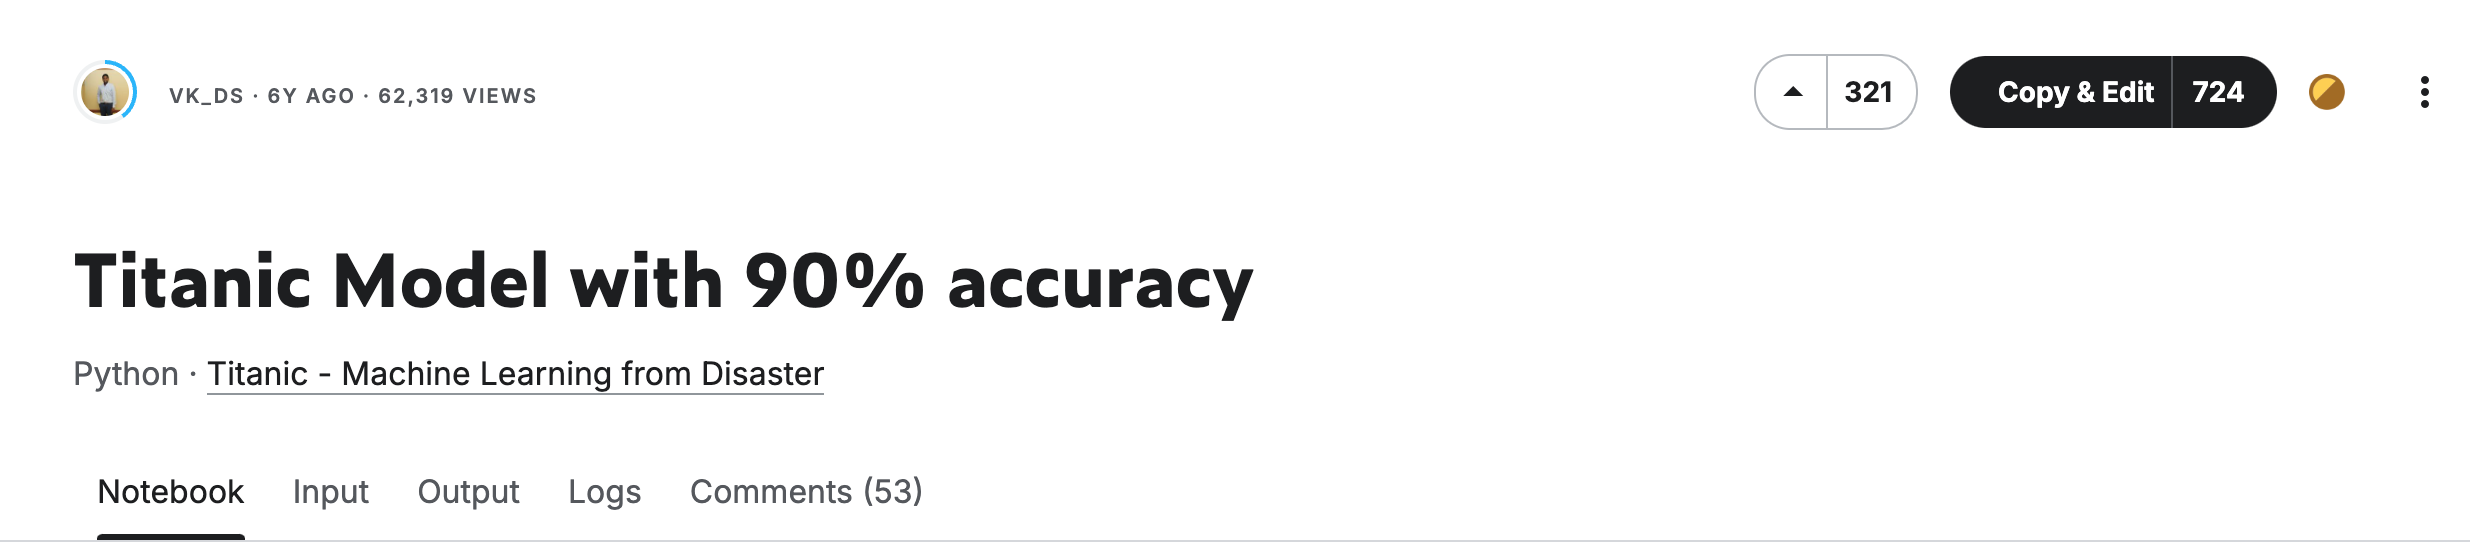

#### Link : <https://www.kaggle.com/code/vinothan/titanic-model-with-90-accuracy>

---

## Load the DataSet

In [80]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [81]:
train_df=pd.read_csv("./train.csv")
test_df=pd.read_csv("./test.csv")

In [82]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [83]:
print('__Test_DataSet_')
test_df.head()

__Test_DataSet_


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


_fun missingdata_  เป็น function สำหรับแสดงค่าจำนวน Feature และ เปอร์เซ็นต์ ที่ missing value

In [84]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms= pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    return ms

In [85]:
missingdata(train_df)

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


In [86]:
missingdata(test_df)

,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


## 2. Filling missing Values

In [87]:
# หาค่าค่าเฉลี่ยของอายุ
test_df['Age'].mean() 

30.272590361445783

In [88]:
# เติมค่าที่ขาดหายไป ในคอลัมน์ 'Embarked' ด้วยค่าที่ปรากฏบ่อยที่สุด ในคอลัมน์นั้นเอง
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace = True) 

In [89]:
# เติมค่าที่ขาดหายไป ในคอลัมน์ 'Fare' ด้วยค่าที่ปรากฏบ่อยที่สุด ในคอลัมน์นั้นเอง
test_df['Fare'].fillna(test_df['Fare'].median(), inplace = True) 

In [90]:
# "Cabin" มีข้อมูลขาดหายมากกว่า 75% ทั้งใน Train และ Test เขาจึงตัด feature นี้ออกไป
drop_column = ['Cabin']
train_df.drop(drop_column, axis=1, inplace = True)
test_df.drop(drop_column,axis=1,inplace=True)

In [91]:
# "Age" ในข้อมูล Train และ Test มีข้อมูลขาดหายมากกว่า 15% เขาจึงเติมข้อมูลที่ขาดหายด้วยค่ามัธยฐาน (median)
test_df['Age'].fillna(test_df['Age'].median(), inplace = True)
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)

In [92]:
# เช็ค missing value อีกครั้ง
print('check the nan value in train data')
print(train_df.isnull().sum())
print('___'*30)
print('check the nan value in test data')
print(test_df.isnull().sum())


check the nan value in train data
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
__________________________________________________________________________________________
check the nan value in test data
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


## 3. Feature engineering

In [93]:
# รวมข้อมูล train และ test เขาด้วยกัน
all_data=[train_df,test_df]

In [94]:
# สร้าง feature ใหม่ ด้วยการรวม SibSp และ Parch
# SibSp จำนวนพี่น้อง/คู่สมรสบนเรือไททานิค
# Parch พ่อแม่/ลูกบนเรือไททานิค
# บวกด้วย 1 (ตัวเอง)
# FamilySize เป็น feature รวมจำนวนทั้งหมดในครอบครัวของคนหนึ่งคน

for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [95]:
import re
# function หาคำนำหน้าชื่อ
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

# สร้างชื่อ "Title" ซึ่งเก็บคำนำหน้าชื่อ
for dataset in all_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# รวมคำนำหน้าชื่อที่ไม่พบบ่อยทั้งหมดเป็นกลุ่มเดียวกันชื่อ "Rare"
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [96]:
# สร้าง "Age_bin" แบ่งค่าในคอลัมน์ "Age" ออกเป็นกลุ่มต่างๆ ตามช่วงอายุที่กำหนด
for dataset in all_data:
    dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])

In [97]:
# สร้าง "Fare_bin" แบ่งค่าในคอลัมน์ "Fare" ออกเป็นกลุ่มต่างๆ ตามช่วงราคาบัตร
for dataset in all_data:
    dataset['Fare_bin'] = pd.cut(dataset['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare',
                                                                                      'Average_fare','high_fare'])

In [98]:
traindf=train_df
testdf=test_df

In [99]:
all_dat=[traindf,testdf]

In [100]:
# ลบ column ที่ไม่ได้ใช้
for dataset in all_dat:
    drop_column = ['Age','Fare','Name','Ticket']
    dataset.drop(drop_column, axis=1, inplace = True)


In [101]:
# ลบ column ที่ไม่ได้ใช้
drop_column = ['PassengerId']
traindf.drop(drop_column, axis=1, inplace = True)

In [102]:
testdf.head(2)

,PassengerId,Pclass,Sex,SibSp,Parch,Embarked,FamilySize,Title,Age_bin,Fare_bin
0,892,3,male,0,0,Q,1,Mr,Adult,Low_fare
1,893,3,female,1,0,S,2,Mrs,Elder,Low_fare


In [103]:
# get_dummies เป็น function สำหรับแปลงข้อมูลเชิงหมวดหมู่ (categorical data) ให้เป็นข้อมูลเชิงตัวเลข (numerical data)
traindf = pd.get_dummies(traindf, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

In [104]:
testdf = pd.get_dummies(testdf, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

In [105]:
testdf.head()

,PassengerId,Pclass,SibSp,Parch,FamilySize,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,...,Age_type_Teenage,Age_type_Adult,Age_type_Elder,Em_type_C,Em_type_Q,Em_type_S,Fare_type_Low_fare,Fare_type_median_fare,Fare_type_Average_fare,Fare_type_high_fare
0,892,3,0,0,1,False,True,False,False,True,...,False,True,False,False,True,False,True,False,False,False
1,893,3,1,0,2,True,False,False,False,False,...,False,False,True,False,False,True,True,False,False,False
2,894,2,0,0,1,False,True,False,False,True,...,False,False,True,False,True,False,False,True,False,False
3,895,3,0,0,1,False,True,False,False,True,...,False,True,False,False,False,True,False,True,False,False
4,896,3,1,1,3,True,False,False,False,False,...,False,True,False,False,False,True,False,True,False,False


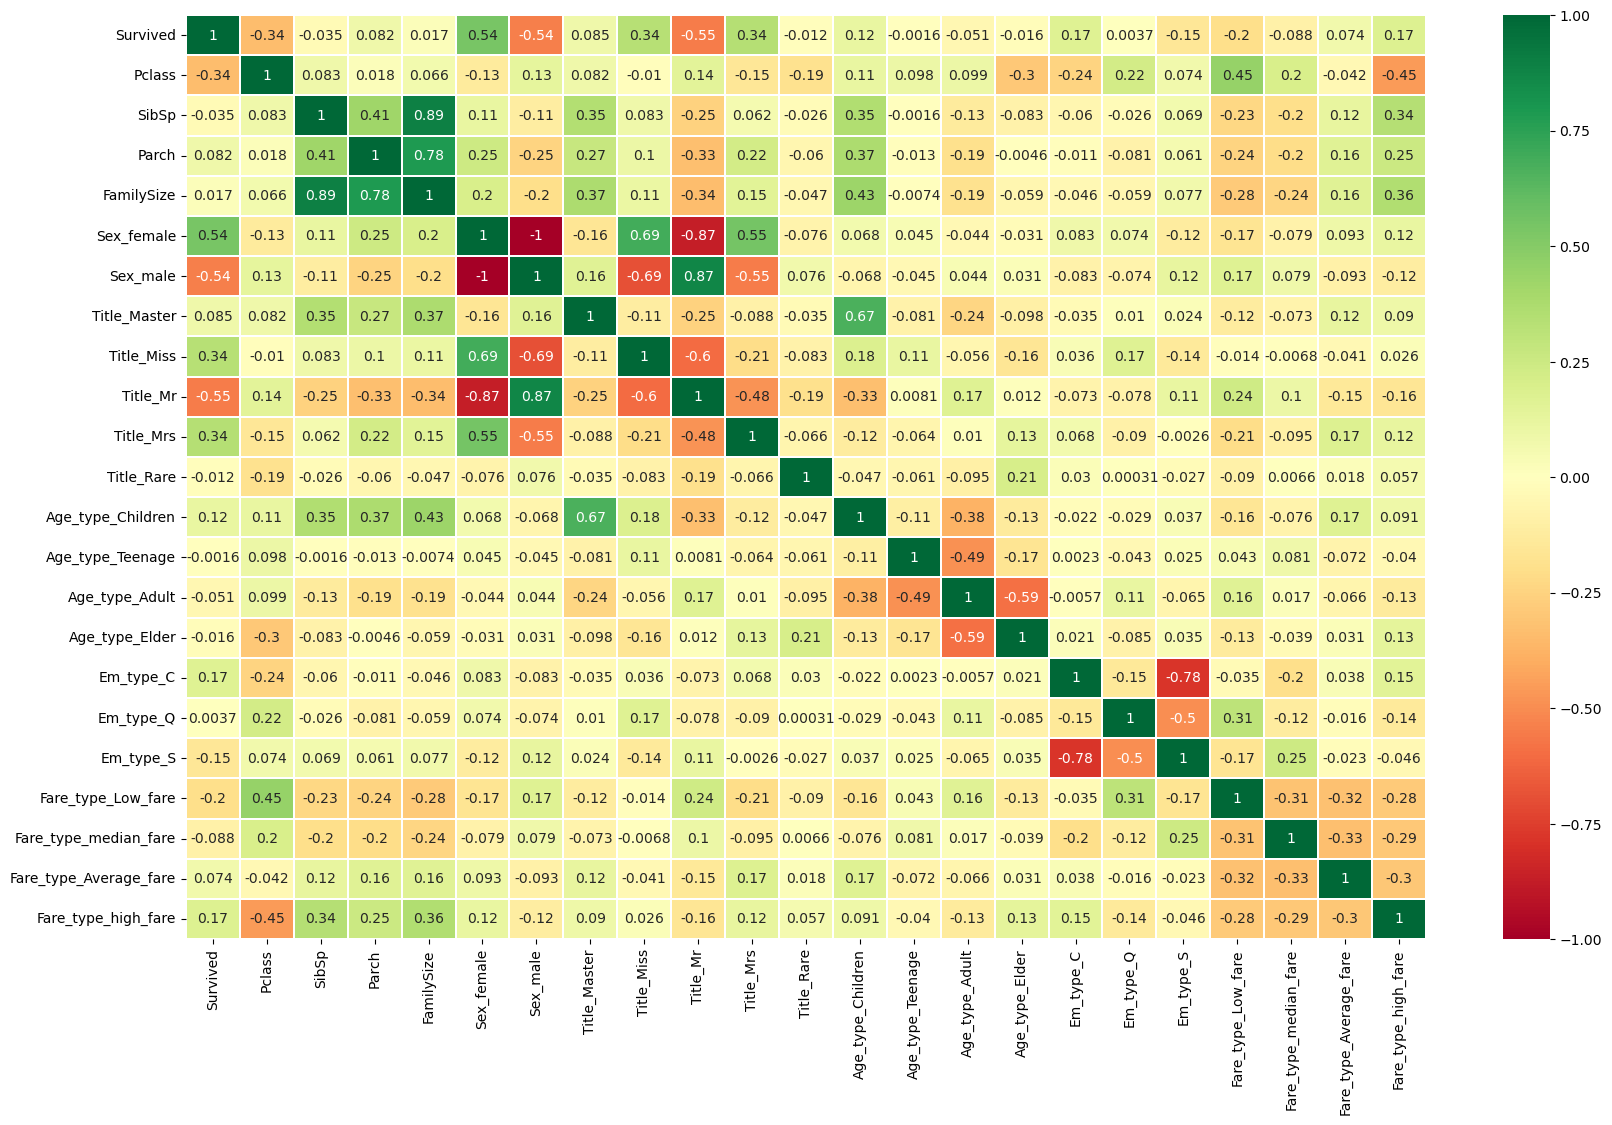

In [106]:
# แสดงความสัมพันธ์ระหว่าง feature ทั้งหมด
sns.heatmap(traindf.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

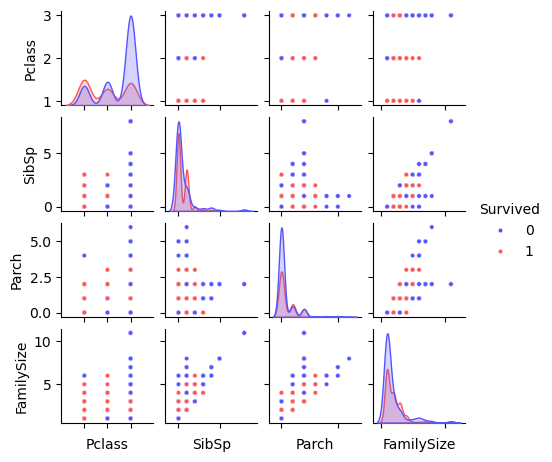

In [107]:
# ใช้ pairplot สร้างกราฟเพื่อสังเกตการกระจายของข้อมูลระหว่าง feature และ lable (Survived) ต่างๆ โดยใช้ Seaborn ช่วย
g = sns.pairplot(data=train_df, hue='Survived', palette = 'seismic', size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

### 4. Modeling

In [108]:
from sklearn.model_selection import train_test_split #for split the data
from sklearn.metrics import accuracy_score  #for accuracy_score
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.metrics import confusion_matrix #for confusion matrix
all_features = traindf.drop("Survived",axis=1)
Targeted_feature = traindf["Survived"]
X_train,X_test,y_train,y_test = train_test_split(all_features,Targeted_feature,test_size=0.3,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((623, 22), (268, 22), (623,), (268,))

#### Random Forest Classifier

Random Forest คือ สร้าง model จาก Decision Tree หลายๆ model ย่อยๆ (ตั้งแต่ 10 model ถึง มากกว่า 1000 model) โดยแต่ละ model จะได้รับ data set ไม่เหมือนกัน ซึ่งเป็น subset ของ data set ทั้งหมด ตอนทำ prediction ก็ให้แต่ละ Decision Tree ทำ prediction ของใครของมัน และคำนวณผล prediction ด้วยการ vote output ที่ ถูกเลือกโดย Decision Tree มากที่สุด (กรณี classification) หรือ หาค่า mean จาก output ของแต่ละ Decision Tree (กรณี regression)

--------------The Accuracy of the model----------------------------
The accuracy of the Random Forest Classifier is 82.46
The cross validated score for Random Forest Classifier is: 83.73


Text(0.5, 1.05, 'Confusion_matrix')

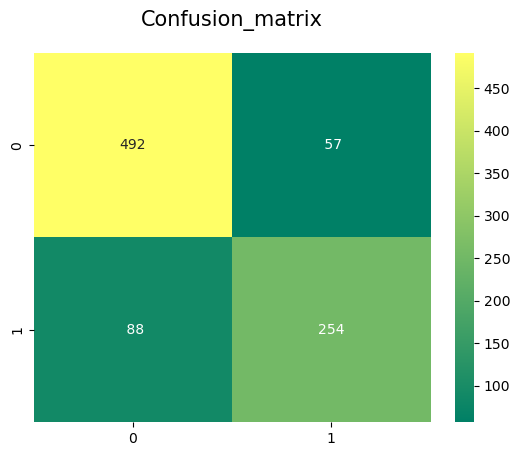

In [109]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(criterion='gini', n_estimators=700,
                             min_samples_split=10,min_samples_leaf=1,oob_score=True,
                             random_state=1,n_jobs=-1)
model.fit(X_train,y_train)
prediction_rm=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Random Forest Classifier is',round(accuracy_score(prediction_rm,y_test)*100,2))
kfold = KFold()
result_rm=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Random Forest Classifier is:',round(result_rm.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

#### Support Vector Machines

เป็นหนึ่งในโมเดล Machine Learning ที่ใช้ในการจำแนกข้อมูล หรือแบ่งกลุ่มข้อมูลโดยจะสร้างเส้นตรงที่ใช้แบ่งกลุ่มข้อมูล (Hyperplane) และหาเส้นที่ดีที่สุด โดยเลือกเส้นที่มี Margin มากที่สุด คือ เส้นที่มีระยะแบ่งกว้างที่สุด  หาก Margin แคบไปขยับข้อมูลเดียวอาจจะทำให้ข้ามไปอีกฝั่งหนึ่งได้ ทำให้มีโอกาส Overfit สูง ดังนั้น ถ้า Margin เยอะ ทำให้ Overfit น้อย หรือเรียกกว่า Soft Margin

--------------The Accuracy of the model----------------------------
The accuracy of the Support Vector Machines Classifier is 83.58
The cross validated score for Support Vector Machines Classifier is: 83.16


Text(0.5, 1.05, 'Confusion_matrix')

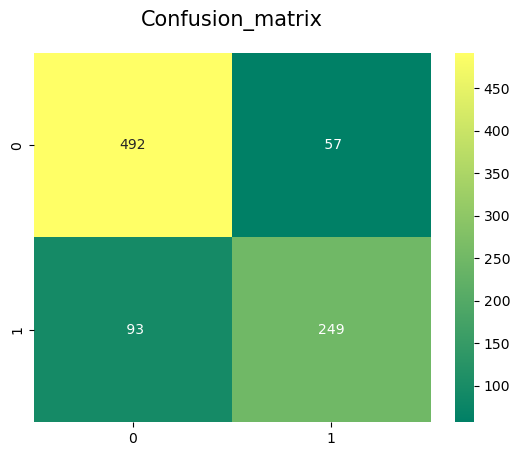

In [110]:
from sklearn.svm import SVC, LinearSVC

model = SVC()
model.fit(X_train,y_train)
prediction_svm=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Support Vector Machines Classifier is',round(accuracy_score(prediction_svm,y_test)*100,2))
kfold = KFold() # k=10, split the data into 10 equal parts
result_svm=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Support Vector Machines Classifier is:',round(result_svm.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

#### KNN Classifier

เป็นวิธีการแบ่งคลาสสำหรับใช้จัดหมวดหมู่ข้อมูล (Classification)ใช้หลักการเปรียบเทียบข้อมูลที่สนใจกับข้อมูลอื่นว่ามีความคล้ายคลึงมากน้อยเพียงใด หากข้อมูลที่กำลังสนใจนั้นอยู่ใกล้ข้อมูลใดมากที่สุด ระบบจะให้คำตอบเป็นเหมือนคำตอบของข้อมูลที่อยู่ใกล้ที่สุดนั้นลักษณะการทำงานแบบไม่ได้ใช้ข้อมูลชุดเรียนรู้ (training data) ในการสร้างแบบจำลองแต่จะใช้ข้อมูลนี้มาเป็นตัวแบบจำลองเลย

--------------The Accuracy of the model----------------------------
The accuracy of the K Nearst Neighbors Classifier is 79.48
The cross validated score for K Nearest Neighbors Classifier is: 80.02


Text(0.5, 1.05, 'Confusion_matrix')

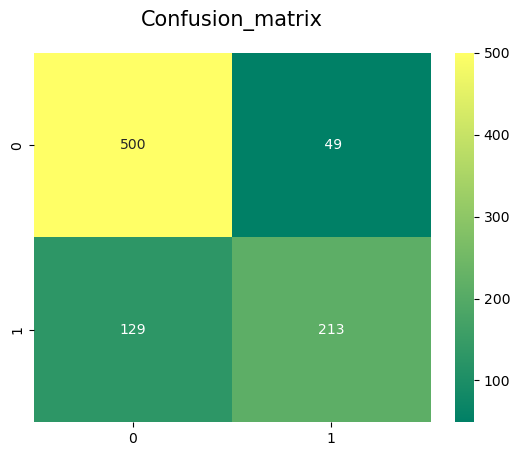

In [111]:
##knn
from sklearn.neighbors import KNeighborsClassifier


model = KNeighborsClassifier(n_neighbors = 4)
model.fit(X_train,y_train)
prediction_knn=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the K Nearst Neighbors Classifier is',round(accuracy_score(prediction_knn,y_test)*100,2))
kfold = KFold() # k=10, split the data into 10 equal parts
result_knn=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for K Nearest Neighbors Classifier is:',round(result_knn.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

#### Gaussian Naive Bayes 

 เป็นการจัดหมวดหมู่โดยใช้หลักความน่าจะเป็นเข้ามาช่วยคำนวณ

 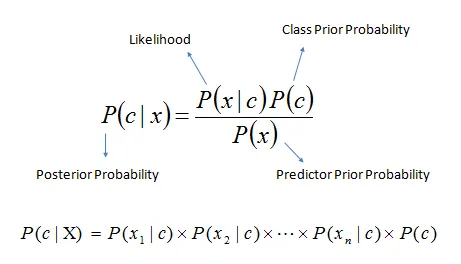

--------------The Accuracy of the model----------------------------
The accuracy of the Gaussian Naive Bayes Classifier is 79.48
The cross validated score for Gaussian Naive Bayes classifier is: 79.8


Text(0.5, 1.05, 'Confusion_matrix')

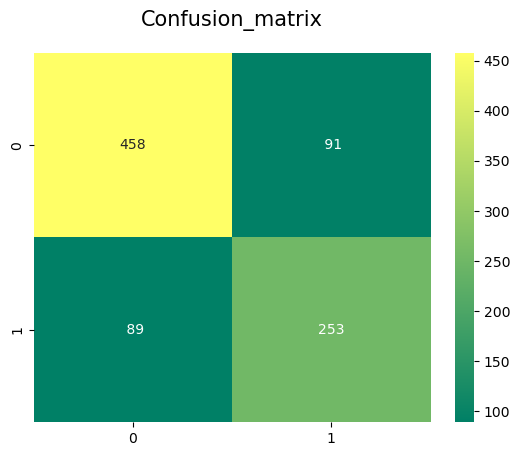

In [112]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
model= GaussianNB()
model.fit(X_train,y_train)
prediction_gnb=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Gaussian Naive Bayes Classifier is',round(accuracy_score(prediction_gnb,y_test)*100,2))
kfold = KFold() # k=10, split the data into 10 equal parts
result_gnb=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Gaussian Naive Bayes classifier is:',round(result_gnb.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

## Model evaluation

เราสามารถจัดอันดับการประเมินของโมเดลทั้งหมดเพื่อเลือกโมเดลที่ดีที่สุดสำหรับปัญหาของเราได้

In [113]:

models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 
              'Random Forest', 'Naive Bayes'
              ],
    'Score': [result_svm.mean(), result_knn.mean(), 
              result_rm.mean(), result_gnb.mean(), 
              ]})
models.sort_values(by='Score',ascending=False)

,Model,Score
2,Random Forest,0.837303
0,Support Vector Machines,0.831648
1,KNN,0.800225
3,Naive Bayes,0.798002


เราสามารถสรุปได้ว่า Random Forest และ SVM classifier มีโอกาสในการทำนายผู้โดยสารเสียชีวิตได้ถูกต้องสูงกว่า

### 5. Hyper-Parameters Tuning

machine learning models เปรียบเสมือนกล่องดำ (Black-Box) มีค่าพารามิเตอร์เริ่มต้นบางอย่างสำหรับกล่องดำนี้ ซึ่งเราสามารถปรับแต่งหรือเปลี่ยนอัตราการเรียนรู้ของอัลกอริทึมเพื่อให้ได้โมเดลที่ดีขึ้น กระบวนการนี้เรียกว่าการปรับแต่งไฮเปอร์พารามิเตอร์

In [114]:
train_X = traindf.drop("Survived", axis=1)
train_Y=traindf["Survived"]
test_X  = testdf.drop("PassengerId", axis=1).copy()
train_X.shape, train_Y.shape, test_X.shape

((891, 22), (891,), (418, 22))

Important features
____________________________________________________________
89.11


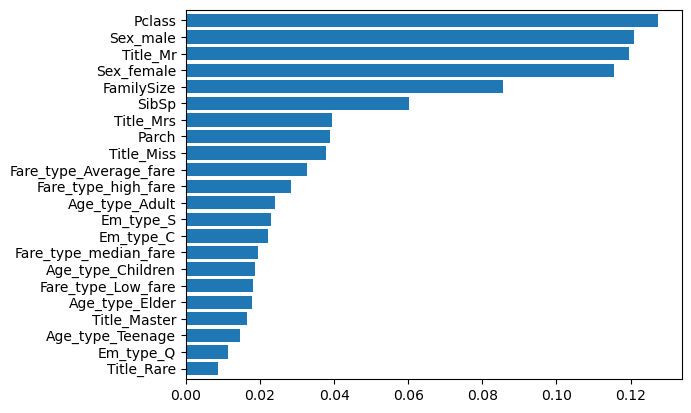

In [115]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(
            bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False
 )
random_forest.fit(train_X, train_Y)
Y_pred_rf = random_forest.predict(test_X)
random_forest.score(train_X,train_Y)
acc_random_forest = round(random_forest.score(train_X, train_Y) * 100, 2)

print("Important features")
pd.Series(random_forest.feature_importances_,train_X.columns).sort_values(ascending=True).plot.barh(width=0.8)
print('__'*30)
print(acc_random_forest)


In [116]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred_rf})